In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import json
import time
from torch import linalg as LA
import re
from collections import defaultdict
import torch
from tqdm import tqdm
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import requests
import torchvision.models as models
import matplotlib.pyplot as plt
# import tensorflow_hub as hub

### Visualization

In [44]:
imageDir = '../input/visual-based-question-answering/train2014/train2014/'
train_questions = json.load(open("../input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json"))['questions']
train_annotations = json.load(open("../input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json"))['annotations']

In [75]:
print('Total number of question:',(len(train_questions)))

Total number of question: 443757


In [46]:
questions_df = pd.DataFrame(train_questions)
questions_df.head()

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000


In [47]:
annotations_df = pd.DataFrame(train_annotations)
annotations_df.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",458752,other,458752000
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",458752,other,458752001
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",458752,other,458752002
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",458752,yes/no,458752003
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",262146,other,262146000


In [48]:
data = pd.merge(questions_df,annotations_df,  how='inner', left_on=['image_id','question_id'], right_on = ['image_id','question_id'])
data

,image_id,question,question_id,question_type,multiple_choice_answer,answers,answer_type
0,458752,What is this photo taken looking through?,458752000,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",other
1,458752,What position is this man playing?,458752001,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",other
2,458752,What color is the players shirt?,458752002,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",other
3,458752,Is this man a professional baseball player?,458752003,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no
4,262146,What color is the snow?,262146000,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",other
...,...,...,...,...,...,...,...
443752,524286,What color is the keyboard?,524286001,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",other
443753,524286,Is there a computer mouse on the desk?,524286002,is there a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",yes/no
443754,524286,What color is the computer?,524286003,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",other
443755,524286,Why are there two keyboards?,524286004,why,one is easier to type on,"[{'answer': 'don't know', 'answer_confidence':...",other


In [49]:
def plotImages(imgDirPath):
    r = np.random.randint(0,len(data),9)
    pos=331
    plt.figure(figsize=(20,20))
    j=0
    for i in r:
        imgFilename = 'COCO_train2014' + '_'+ str(data['image_id'][i]).zfill(12) + '.jpg'
        ax = plt.subplot(pos+j)
        img = cv2.imread(imgDirPath+imgFilename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.title.set_text('Ques. '+data['question'][i]+'\nAns. '+data['multiple_choice_answer'][i])
        ax.axis('off')
        j=j+1

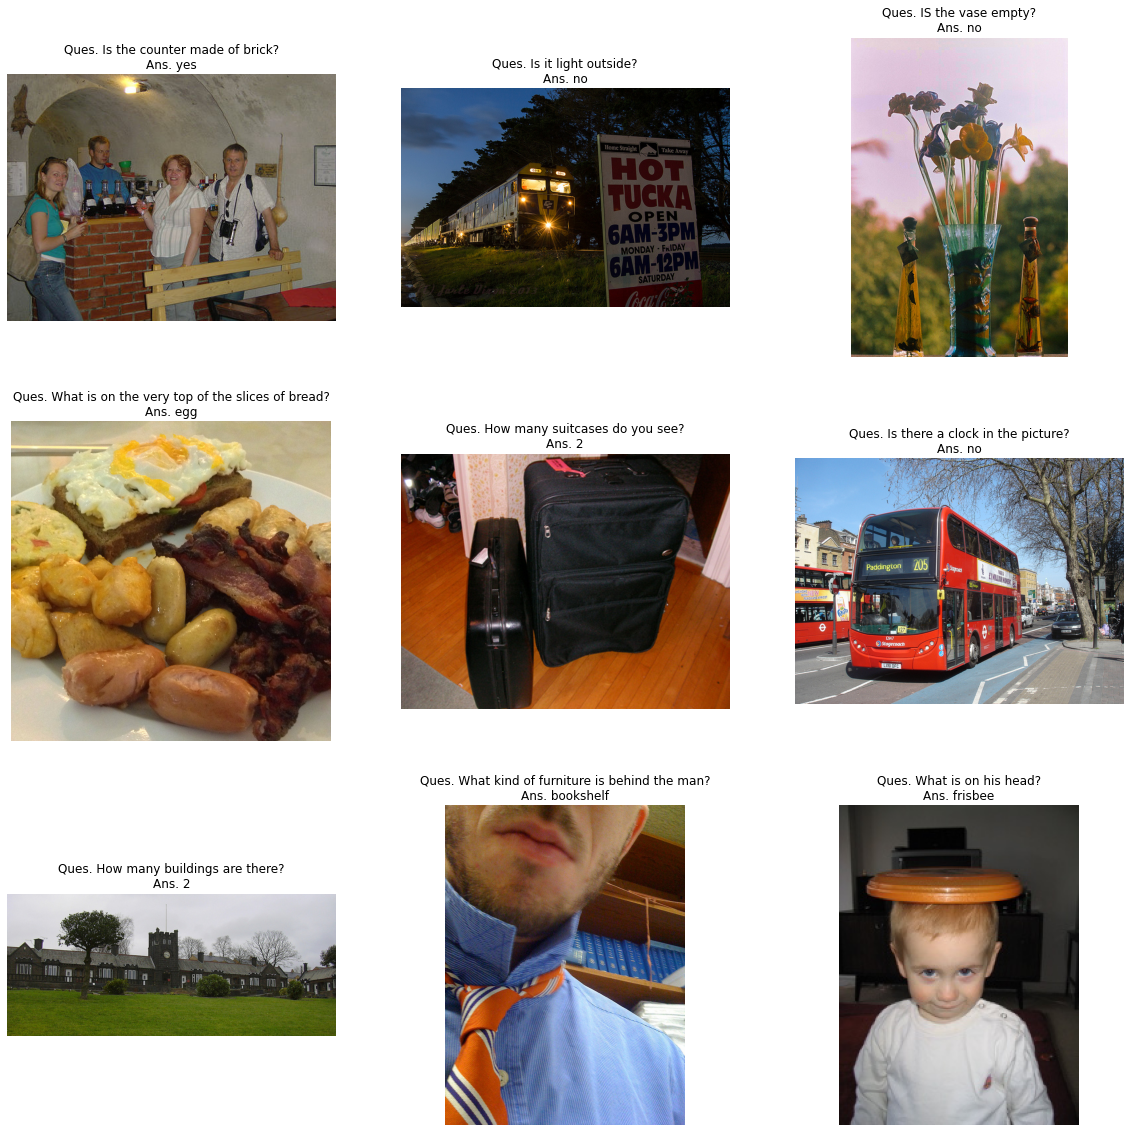

In [50]:
plotImages(imageDir)

In [51]:
def getPeopleAnswer(answers):
    answers_dict = {}
    score_dict = { 'yes' : 3, 'maybe' : 2, 'no' : 1 }
    for _answer in answers:
        score = score_dict[_answer['answer_confidence']]
        if answers_dict.get(_answer['answer'],-1) != -1 :
            answers_dict[_answer['answer']] += score
        else:
            answers_dict[_answer['answer']] = score

    return sorted(list(answers_dict.items()),key = lambda x: x[1],reverse=True)[0][0]

In [73]:
data['derived_answer'] =  data["answers"].apply(lambda x: getPeopleAnswer(x))
data

,image_id,question,question_id,question_type,multiple_choice_answer,answers,answer_type,derived_answer
0,458752,What is this photo taken looking through?,458752000,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",other,net
1,458752,What position is this man playing?,458752001,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",other,pitcher
2,458752,What color is the players shirt?,458752002,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",other,orange
3,458752,Is this man a professional baseball player?,458752003,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",yes/no,yes
4,262146,What color is the snow?,262146000,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",other,white
...,...,...,...,...,...,...,...,...
443752,524286,What color is the keyboard?,524286001,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",other,black
443753,524286,Is there a computer mouse on the desk?,524286002,is there a,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",yes/no,no
443754,524286,What color is the computer?,524286003,what color is the,black,"[{'answer': 'black', 'answer_confidence': 'yes...",other,black
443755,524286,Why are there two keyboards?,524286004,why,one is easier to type on,"[{'answer': 'don't know', 'answer_confidence':...",other,two computers


### VQA

In [12]:
def make_vocab_questions(input_dir):
    """Make dictionary for questions and save them into text file."""
    vocab_set = set()
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question_length = []
#     datasets = os.listdir(input_dir)
    for imp in input_dir:    
        with open(imp) as f:
            questions = json.load(f)['questions']
        set_question_length = [None]*len(questions)
        for iquestion, question in enumerate(questions):
            words = SENTENCE_SPLIT_REGEX.split(question['question'].lower())
            words = [w.strip() for w in words if len(w.strip()) > 0]
            vocab_set.update(words)
            set_question_length[iquestion] = len(words)
        question_length += set_question_length

    vocab_list = list(vocab_set)
    vocab_list.sort()
    vocab_list.insert(0, '<pad>')
    vocab_list.insert(1, '<unk>')
    print('\nWriting Question File')
    with open('./datasets/vocab_questions.txt', 'w') as f:
        f.writelines([w+'\n' for w in vocab_list])
    print('File Written\n')
    print('Make vocabulary for questions')
    print('The number of total words of questions: %d' % len(vocab_set))
    print('Maximum length of question: %d' % np.max(question_length))


def make_vocab_answers(input_dir, n_answers):
    """Make dictionary for top n answers and save them into text file."""
    answers = defaultdict(lambda: 0)
#     datasets = os.listdir(input_dir)
    for inp in input_dir:
        with open(inp) as f:
            annotations = json.load(f)['annotations']
        for annotation in annotations:
            for answer in annotation['answers']:
                word = answer['answer']
                if re.search(r"[^\w\s]", word):
                    continue
                answers[word] += 1
                
    answers = sorted(answers, key=answers.get, reverse=True)
    assert('<unk>' not in answers)
    top_answers = ['<unk>'] + answers[:n_answers-1] # '-1' is due to '<unk>'
    print('\nWriting Answer File')
    with open('./datasets/vocab_answers.txt', 'w') as f:
        f.writelines([w+'\n' for w in top_answers])
    print('File Written\n')
    print('Make vocabulary for answers')
    print('The number of total words of answers: %d' % len(answers))
    print('Keep top %d answers into vocab' % n_answers)

In [13]:
os.makedirs('./datasets', exist_ok=True)

In [14]:
# input_dir_q = ['../input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json','../input/visual-based-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json']
# input_dir_a = ['../input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json','../input/visual-based-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json']

# n_answers = 1000
# make_vocab_questions(input_dir_q)
# make_vocab_answers(input_dir_a, n_answers)

In [15]:
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')


def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens


def load_str_list(fname):
    with open(fname) as f:
        lines = f.readlines()
    lines = [l.strip() for l in lines]
    return lines


class VocabDict:

    def __init__(self, vocab_file):
        self.word_list = load_str_list(vocab_file)
        self.word2idx_dict = {w:n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError('word %s not in dictionary (while dictionary does not contain <unk>)' % w)

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds

In [16]:
def extract_answers(q_answers, valid_answer_set):
    all_answers = [answer["answer"] for answer in q_answers]
    valid_answers = [a for a in all_answers if a in valid_answer_set]
    return all_answers, valid_answers


def vqa_processing(image_dir, annotation_file, question_file, valid_answer_set, image_set):
    print('building vqa %s dataset' % image_set)
    if image_set in ['train2014', 'val2014']:
        load_answer = True
        with open(annotation_file) as f:
            annotations = json.load(f)['annotations']
            qid2ann_dict = {ann['question_id']: ann for ann in annotations}
    else:
        load_answer = False
    with open(question_file) as f:
        questions = json.load(f)['questions']
#     coco_set_name = image_set.replace('-dev', '')
    abs_image_dir = os.path.abspath(image_dir)
#     image_name_template = 'COCO_'+image_set + '_'+ str(data['image_id'][i]).zfill(12) + '.jpg'
    image_name_template = 'COCO_'+image_set+'_%012d'
    dataset = [None]*len(questions)
    
    unk_ans_count = 0
    for n_q, q in enumerate(questions):
        if (n_q+1) % 20000 == 0:
            print('processing %d / %d' % (n_q+1, len(questions)))
        image_id = q['image_id']
        question_id = q['question_id']
        image_name = image_name_template % image_id
        image_path = os.path.join(abs_image_dir, image_name+'.jpg')
        question_str = q['question']
        question_tokens = tokenize(question_str)
        
        iminfo = dict(image_name=image_name,
                      image_path=image_path,
                      question_id=question_id,
                      question_str=question_str,
                      question_tokens=question_tokens)
        
        if load_answer:
            ann = qid2ann_dict[question_id]
            all_answers, valid_answers = extract_answers(ann['answers'], valid_answer_set)
            if len(valid_answers) == 0:
                valid_answers = ['<unk>']
                unk_ans_count += 1
            iminfo['all_answers'] = all_answers
            iminfo['valid_answers'] = valid_answers
            
        dataset[n_q] = iminfo
    print('total %d out of %d answers are <unk>' % (unk_ans_count, len(questions)))
    return dataset

In [17]:

# image_dir = '../input/visual-based-question-answering/train2014/train2014/'
# annotation_file = '../input/visual-based-question-answering/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json'
# question_file = '../input/visual-based-question-answering/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json'

# vocab_answer_file = './datasets'+'/vocab_answers.txt'
# answer_dict = VocabDict(vocab_answer_file)
# valid_answer_set = set(answer_dict.word_list)    

# train = vqa_processing(image_dir, annotation_file, question_file, valid_answer_set, 'train2014')
# print('saving file')
# np.save('./datasets'+'/train.npy', np.array(train))


In [18]:
# image_dir = '../input/visual-based-question-answering/val2014/val2014/'
# annotation_file = '../input/visual-based-question-answering/v2_Annotations_Val_mscoco/v2_mscoco_val2014_annotations.json'
# question_file = '../input/visual-based-question-answering/v2_Questions_Val_mscoco/v2_OpenEnded_mscoco_val2014_questions.json'

# vocab_answer_file = './datasets'+'/vocab_answers.txt'
# answer_dict = VocabDict(vocab_answer_file)
# valid_answer_set = set(answer_dict.word_list)    


# valid = vqa_processing(image_dir, annotation_file, question_file, valid_answer_set, 'val2014')
# np.save('./datasets'+'/valid.npy', np.array(valid))

In [19]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class VqaDataset(data.Dataset):

    def __init__(self, input_dir, input_vqa, max_qst_length=30, max_num_ans=10, transform=None):
        self.input_dir = input_dir
        self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True)[:20000]
        self.qst_vocab = VocabDict(input_dir+'/vocab_questions.txt')
        self.ans_vocab = VocabDict(input_dir+'/vocab_answers.txt')
        self.max_qst_length = max_qst_length
        self.max_num_ans = max_num_ans
        self.load_ans = ('valid_answers' in self.vqa[0]) and (self.vqa[0]['valid_answers'] is not None)
        self.transform = transform

    def __getitem__(self, idx):

        vqa = self.vqa
        qst_vocab = self.qst_vocab
        ans_vocab = self.ans_vocab
        max_qst_length = self.max_qst_length
        max_num_ans = self.max_num_ans
        transform = self.transform
        load_ans = self.load_ans

        image = vqa[idx]['image_path']
        image = Image.open(image).convert('RGB')
        qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
        qst2idc[:len(vqa[idx]['question_tokens'])] = [qst_vocab.word2idx(w) for w in vqa[idx]['question_tokens']]
        print('question_tokens', vqa[idx]['question_tokens'])
        qst2idc = torch.Tensor(qst2idc).to(device)
#         sample = {'image': image, 'question': qst2idc}

        if load_ans:
            ans2idc = [ans_vocab.word2idx(w) for w in vqa[idx]['valid_answers']]
            print('valid_answers', vqa[idx]['valid_answers'])

            ans2idx = [np.random.choice(ans2idc)]
            ans2idx = torch.Tensor(ans2idx).to(device)
#             sample['answer_label'] = ans2idx[0]         # for training

            mul2idc = list([-1] * max_num_ans)       # padded with -1 (no meaning) not used in 'ans_vocab'
            mul2idc[:len(ans2idc)] = ans2idc      # our model should not predict -1
            print('mul2idc', mul2idc)

#             sample['answer_multi_choice'] = mul2idc  # for evaluation metric of 'multiple choice'

        if transform:
            image = transform(image).to(device)
#             sample['image'] = transform(sample['image']).to(device)

        return image, qst2idc,ans2idx[0],mul2idc


    def __len__(self):

        return len(self.vqa)


def get_dataset(input_dir, input_vqa_train, input_vqa_valid, max_qst_length, max_num_ans):

    transform = {
        phase: transforms.Compose([transforms.ToTensor(),
                                   transforms.Resize(256), 
                                   transforms.CenterCrop(224), # resize the image to 224x224
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))]) 
        for phase in ['train', 'valid']}

    vqa_dataset = {
        'train': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_train,
            max_qst_length=max_qst_length,
            max_num_ans=max_num_ans,
            transform=transform['train']),
        'valid': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_valid,
            max_qst_length=max_qst_length,
            max_num_ans=max_num_ans,
            transform=transform['valid'])}

    return vqa_dataset

In [21]:
vqa_dataset = get_dataset( input_dir='../input/npy-vqa-data/datasets', input_vqa_train='train.npy', input_vqa_valid='valid.npy',
                          max_qst_length=30, max_num_ans=10)

In [22]:
train_dataloader = torch.utils.data.DataLoader(dataset=vqa_dataset['train'], batch_size=1, shuffle=True,drop_last = True)
val_dataloader = torch.utils.data.DataLoader(dataset=vqa_dataset['valid'], batch_size=1, shuffle=True,drop_last = True)

In [23]:
class ImgEncoder(nn.Module):

    def __init__(self, embed_size):
        super(ImgEncoder, self).__init__()
        model = models.vgg16(pretrained=True)
        in_features = model.classifier[-1].in_features  # input size of feature vector
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1])    # remove last fc layer

        self.model = model.to(device)                              # loaded model without last fc layer
        self.fc = nn.Linear(in_features, embed_size)    # feature vector of image

    def forward(self, image):
        """Extract feature vector from image vector.
        """
        model.eval()
        img_feature = self.model(image)                  # [batch_size, vgg16(19)_fc=4096]
        img_feature = self.fc(img_feature)                   # [batch_size, embed_size]

        l2_norm = LA.norm(img_feature,dim=1, keepdim=True )
        img_feature = img_feature.div(l2_norm)               # l2-normalized feature vector

        return img_feature


class QstEncoder(nn.Module):

    def __init__(self, qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size):

        super(QstEncoder, self).__init__()
        self.word2vec = nn.Embedding(qst_vocab_size, word_embed_size)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(2*num_layers*hidden_size, embed_size)     # 2 for hidden and cell states

    def forward(self, question):

        qst_vec = self.word2vec(question)                             # [batch_size, max_qst_length=30, word_embed_size=300]
        qst_vec = self.tanh(qst_vec)
        qst_vec = qst_vec.transpose(0, 1)                             # [max_qst_length=30, batch_size, word_embed_size=300]
        _, (hidden, cell) = self.lstm(qst_vec)                        # [num_layers=2, batch_size, hidden_size=512]
        qst_feature = torch.cat((hidden, cell), 2)                    # [num_layers=2, batch_size, 2*hidden_size=1024]
        qst_feature = qst_feature.transpose(0, 1)                     # [batch_size, num_layers=2, 2*hidden_size=1024]
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1)  # [batch_size, 2*num_layers*hidden_size=2048]
        qst_feature = self.tanh(qst_feature)
        qst_feature = self.fc(qst_feature)                            # [batch_size, embed_size]

        return qst_feature


class VqaModel(nn.Module):

    def __init__(self, embed_size, qst_vocab_size, ans_vocab_size, word_embed_size, num_layers, hidden_size):

        super(VqaModel, self).__init__()
        self.img_encoder = ImgEncoder(embed_size)
        self.qst_encoder = QstEncoder(qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_size, ans_vocab_size)
        self.fc2 = nn.Linear(ans_vocab_size, ans_vocab_size)

    def forward(self, img, qst):

        img_feature = self.img_encoder(img)                     # [batch_size, embed_size]
        qst_feature = self.qst_encoder(qst)                     # [batch_size, embed_size]
        combined_feature = torch.mul(img_feature, qst_feature)  # [batch_size, embed_size]
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc1(combined_feature)           # [batch_size, ans_vocab_size=1000]
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        combined_feature = self.fc2(combined_feature)           # [batch_size, ans_vocab_size=1000]

        return combined_feature

In [24]:
os.makedirs('./logs', exist_ok=True)
os.makedirs('./models', exist_ok=True)

qst_vocab_size = train_dataloader.dataset.qst_vocab.vocab_size
ans_vocab_size = train_dataloader.dataset.ans_vocab.vocab_size
ans_unk_idx = train_dataloader.dataset.ans_vocab.unk2idx

In [25]:
model = VqaModel(1024, qst_vocab_size, ans_vocab_size, 300, 2, 512).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [26]:
criterion = nn.CrossEntropyLoss().to(device)

params = list(model.img_encoder.fc.parameters()) \
    + list(model.qst_encoder.parameters()) \
    + list(model.fc1.parameters()) \
    + list(model.fc2.parameters())

In [27]:
optimizer = optim.Adam(params, lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [28]:
def test_case(model, test_sent, image ):
    model.load_state_dict(torch.load('../input/training-vqa-logs/model-epoch-30.ckpt')['state_dict'])
    inp ='../input/npy-vqa-data/datasets'
    x_ques = VocabDict(inp+'/vocab_questions.txt')
    x_ans = VocabDict(inp+'/vocab_answers.txt')

    test_ques = np.array([x_ques.word2idx('<pad>')] * 30)  # padded with '<pad>' in 'ans_vocab'
    tkns = x_ques.tokenize_and_index(test_sent)
    test_ques[:len(tkns)] = tkns
    test_ques = torch.tensor([test_ques]).type(torch.LongTensor).to(device)
    tr_form_norm = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize(256), 
                              transforms.CenterCrop(224)])
    tr_form_aug = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize(224), 
                              transforms.CenterCrop(224),
                              transforms.Normalize((0.485, 0.456, 0.406),
                                                   (0.229, 0.224, 0.225))])
    
    
    cam = Grad_CAM(model)
    img = tr_form_aug(image).to(device)
    img= img.view(1, 3, 224, 224)
    heatmaps, values, indices = cam.get_grad_cam(img, test_ques)

    # Visualize the heatmaps
    rgb_img = np.transpose(tr_form_norm(image).view(1, 3, 224, 224).numpy()[0], [1,2,0])
    fig = plot_heatmaps(rgb_img, heatmaps, values, indices)
    fig.show()

In [29]:
#### Training VQA model

# epochs = 30
# for epoch in range(epochs):

#     for phase in ['train', 'valid']:
        
#         if phase == 'train':
#             data_loader = train_dataloader
#         else:
#             data_loader = val_dataloader

#         running_loss = 0.0
#         running_corr_exp1 = 0
#         running_corr_exp2 = 0

#         batch_step_size = len(data_loader.dataset) / batch_size

#         if phase == 'train':
#             scheduler.step()
#             model.train()
#         else:
#             model.eval()
            
#         for batch_idx, (image, question,answer_label, answer_multi_choice) in tqdm(enumerate(data_loader)):

#             image = image.to(device)
#             question = question.type(torch.LongTensor).to(device)
#             label = answer_label.type(torch.LongTensor).to(device)
#             multi_choice = answer_multi_choice  # not tensor, list.

#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):

#                 output = model(image, question)      # [batch_size, ans_vocab_size=1000]
#                 _, pred_exp1 = torch.max(output, 1)  # [batch_size]
#                 _, pred_exp2 = torch.max(output, 1)  # [batch_size]
#                 loss = criterion(output, label)

#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # Evaluation metric of 'multiple choice'
#             # Exp1: our model prediction to '<unk>' IS accepted as the answer.
#             # Exp2: our model prediction to '<unk>' is NOT accepted as the answer.
            
            
#             pred_exp2[pred_exp2 == ans_unk_idx] = -9999
#             running_loss += loss.item()
                        
#             running_corr_exp1 += torch.stack([(ans == pred_exp1.cpu()) for ans in multi_choice]).any(dim=0).sum()
#             running_corr_exp2 += torch.stack([(ans == pred_exp2.cpu()) for ans in multi_choice]).any(dim=0).sum()

#              # Print the average loss in a mini-batch.
#             if batch_idx % 100 == 0:
#                 print('| {} SET | Epoch [{:02d}/{:02d}], Step [{:04d}/{:04d}], Loss: {:.4f}'
#                       .format(phase.upper(), epoch+1, epochs, batch_idx, int(batch_step_size), loss.item()))

#         # Print the average loss and accuracy in an epoch.
#         epoch_loss = running_loss / batch_step_size
#         epoch_acc_exp1 = running_corr_exp1.double() / len(data_loader.dataset)      # multiple choice
#         epoch_acc_exp2 = running_corr_exp2.double() / len(data_loader.dataset)      # multiple choice
        
#         print('| {} SET | Epoch [{:02d}/{:02d}], Loss: {:.4f}, Acc(Exp1): {:.4f}, Acc(Exp2): {:.4f} \n'
#                   .format(phase.upper(), epoch+1, epochs, epoch_loss, epoch_acc_exp1, epoch_acc_exp2))

#         # Log the loss and accuracy in an epoch.
#         with open(os.path.join('./logs', '{}-log-epoch-{:02}.txt')
#                   .format(phase, epoch+1), 'w') as f:
#             f.write(str(epoch+1) + '\t'
#                     + str(epoch_loss) + '\t'
#                     + str(epoch_acc_exp1.item())+ '\t'
#                         + str(epoch_acc_exp2.item()))

#     # Save the model check points.
#     if (epoch+1) % 1 == 0:
#         torch.save({'epoch': epoch+1, 'state_dict': model.state_dict()},
#                    os.path.join('./models', 'model-epoch-{:02d}.ckpt'.format(epoch+1)))

In [30]:
import torch.nn.functional as F
from torch.autograd import grad

class Grad_CAM():
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradient = None
        
        # register hooks to capture the feature_map gradients
        def forward_hook(model, input, output):
            self.activations = output[0]                       
            
        def backward_hook(model, grad_input, grad_output):
            self.gradient = grad_output[0][0]                      
            
        feat_map = model.img_encoder.model.features[29]         ####### Relu layer
        feat_map.register_forward_hook(forward_hook)
        feat_map.register_backward_hook(backward_hook)
        
    def get_grad_cam(self, img,ques, indices = None):
        self.model.eval()
        out = self.model(img,ques)         ### 1*1000
        num_features = self.activations.size()[0]    #### 512 *14*14
        topk = 3  
        if indices == None:
            values, indices = torch.topk(out, topk)
            values = values.detach().cpu()
            indices = indices.detach().cpu()
        else:
            values = torch.tensor([np.array(range(4,1,-1))])
            indices = torch.tensor([indices])
        # Compute 14x14 heatmaps
        heatmaps = torch.zeros(topk,14,14)
        for i,c in enumerate(indices[0]):
            self.model.zero_grad()
            out[0,c].backward(retain_graph=True)             #### 512 *14*14
            # feature importance
            feature_importance = self.gradient.mean(dim=[1,2]).detach().cpu()         #######  512
            # pixel importance
            self.activations = self.activations.detach().cpu()

            for f in range(num_features):
                heatmaps[i] += feature_importance[f] * self.activations[f]      ### int * [14*14]    512*14*14
            heatmaps[i] = F.relu(heatmaps[i])
            heatmaps[i] /= torch.max(heatmaps[i])
        # Upsample to 224x224
        large_heatmaps = F.interpolate(heatmaps.expand((1,topk,14,14)), (224,224), mode='bilinear')
        return large_heatmaps[0].data.numpy(), values.data.numpy()[0], indices.data.numpy()[0]

In [41]:
def plot_heatmaps(img, heatmaps, values = None, indices = None):
    fig, axs = plt.subplots(figsize=(18, 5), ncols=4)
    for k in range(1,4):
        ax = axs[k]
        ax.imshow(img)
        h = ax.imshow(heatmaps[k-1], cmap='jet', alpha=0.4)        
        title = 'Top '+str(k)
        if values is not None and indices is not None:
            title += '\nclass '+str(indices[k-1])
            title += '    score '+str(np.round(values[k-1],2))
        ax.set_title(title, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        cbar = fig.colorbar(h, ax=ax, )
        cbar.ax.tick_params(labelsize=14)
    ax = axs[0]
    ax.imshow(img)
    title = 'Orignal image'
    ax.set_title(title, fontsize=18)
    fig.tight_layout()
    inp ='../input/npy-vqa-data/datasets'
    x_ans = VocabDict(inp+'/vocab_answers.txt')
    titles = [x_ans.idx2word(indices[0]), x_ans.idx2word(indices[1]), x_ans.idx2word(indices[2])]
    suptitle = '\nTop 1: '+titles[0]+'\nTop 2: '+titles[1]+'\nTop 3: '+titles[2]
    fig.suptitle(suptitle, x=0.4, y=1.3, fontsize=20, ha='left', va='top')
    return fig

In [32]:
torch.backends.cudnn.enabled = False

In [33]:
# loss_logs = []
# for f_name in sorted(os.listdir('../input/dataset/logs')):
#     if 'valid' in f_name:
#         with open('../input/dataset/logs/' + f_name) as f:
#             lines = f.readlines()
#         loss_logs.append(lines[0].split('\t'))
# df = pd.DataFrame(loss_logs, columns = ['Epoch','Loss','Acc1','Acc2'])
# df['Epoch'] = pd.to_numeric(df['Epoch'])
# df['Loss'] = pd.to_numeric(df['Loss'])
# df['Acc1'] = pd.to_numeric(df['Acc1'])
# df['Acc2'] = pd.to_numeric(df['Acc2'])
# df.to_csv('val_logs.csv')

In [34]:
df_train = pd.read_csv('../input/training-vqa-logs/logs.csv')
df_val = pd.read_csv('../input/training-vqa-logs/val_logs.csv')

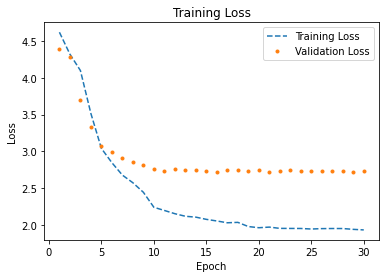

In [35]:
x = df_train['Epoch']
tr_loss = df_train['Loss']
val_loss = df_val['Loss']
tr_acc1 = df_train['Acc1']
tr_acc2 = df_train['Acc2']
val_acc1 = df_val['Acc1']
val_acc2 = df_val['Acc2']

plt.plot(x, tr_loss, '--', label='Training Loss')
plt.plot(x, val_loss, '.', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

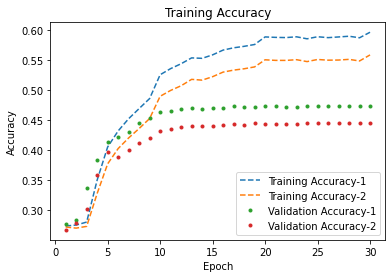

In [36]:
plt.plot(x, tr_acc1, '--', label='Training Accuracy-1')
plt.plot(x, tr_acc2, '--', label='Training Accuracy-2')
plt.plot(x, val_acc1, '.', label='Validation Accuracy-1')
plt.plot(x, val_acc2, '.', label='Validation Accuracy-2')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

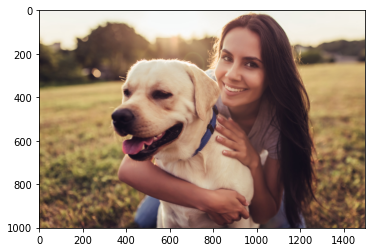

In [37]:
url = 'https://www.simplemost.com/wp-content/uploads/2019/10/dog-owner.jpeg'
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)

Enter Question :   What is girl holding?


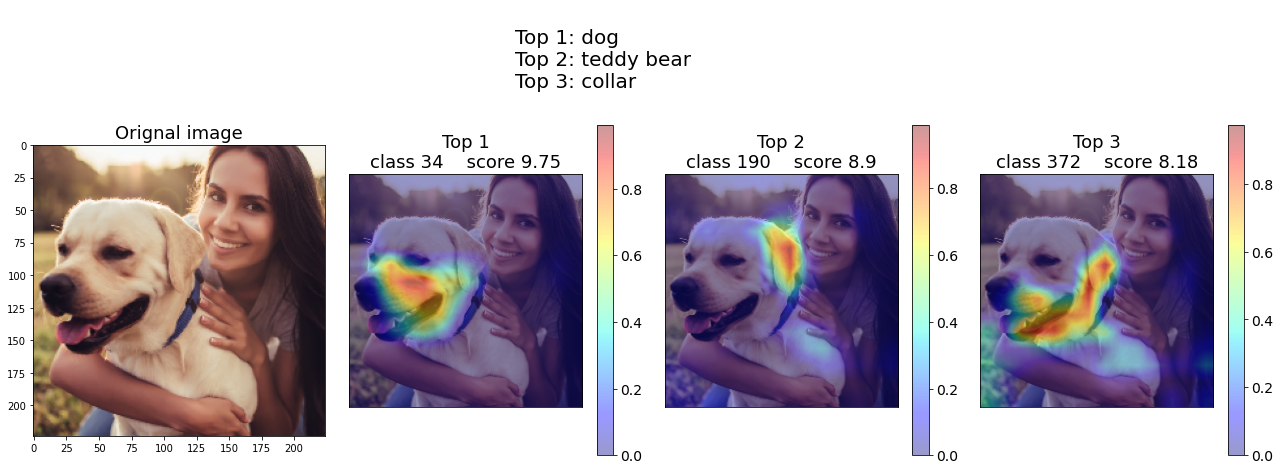

In [42]:
test_sent = input('Enter Question : ')
test_case(model, test_sent, image )